In [7]:
# script to see when england and scotland have same length days
import requests
import lxml.html as lh
import pandas as pd
from datetime import datetime
import time
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter



In [8]:
#function to scrape sun times from the sunrise-sunset website. location is lowercase
def sunsetscraper(location):
    df=pd.DataFrame
    print(location)

    col=[]
    idx =[]
    i=0
    dicts={}
    roll = 0

    for months in range(1,13):
        print(months,)
        website_url = requests.get('https://sunrise-sunset.org/search?location='+location+'&year=2020&month='+str(months)+'#calendar')
              
        doc = lh.fromstring(website_url.content)
        try:
            name = doc.xpath('//p[contains(text(),"in")]/text()')
            name = name[1]
        except:
            print('Error reading location')
            print('https://sunrise-sunset.org/search?location='+location+'&year=2020&month='+str(months)+'#calendar')
            break
            
        place = name[name.find('in')+len('in'):name.rfind(".")]

        tr_elements = doc.xpath('//tr')
        #For each row, store each first element (header) and an empty list
        # for t in range(1,len(tr_elements)):
        for day in range(0,len(tr_elements)):
            col=[]
        #     if day == 0:
            if roll ==0:
                roll = 1
                for ct, t in enumerate(tr_elements[0]):
                    name=t.text_content()
                    #print('%d:"%s"'%(i,name))
                    if ct < 7:
                        idx.append(name) #add this as index
 
            if day > 1:    
                for count, t in enumerate(tr_elements[day]):
                    if count == 0:
                        date = t.text_content()#Wed, Jan 1
                        dts = datetime.strptime("2020"+date,'%Y%a, %b %d').date()
#                         print(dts)
                        
#                         datestr = dts.strftime("%a-%d-%m")
                        i+=1
                       # print(date)
                    elif count >6:
                        continue
                    else:
                        i+=1
                        name=t.text_content()
                       # print(date+" "+name)
                       # print(name)
                        if name.find("m")!= -1:
                            if name.count(":")==1:
                                dt = datetime.strptime("2020"+date+" "+name,'%Y%a, %b %d %I:%M %p') 
                                dt = dt.strftime("%H.%M")
                                hr, mint = int(dt[:2]),int(dt[-2:])
                                dt = hr+mint/60
                            elif name.count(":")==2:
                               
                                dt = datetime.strptime("2020"+date+" "+name,'%Y%a, %b %d %I:%M:%S %p')
                                dt = dt.strftime("%H.%M")
                                hr, mint = int(dt[:2]),int(dt[-2:])
                                dt = hr+mint/60
                        else:
                            dt = datetime.strptime("2020"+date+" "+name,'%Y%a, %b %d %H:%M:%S')
                            dt = dt.strftime("%H.%M")
                            hr, mint = int(dt[:2]),int(dt[-2:])
                            dt = hr+mint/60
                #         print('%d:"%s"'%(i,name))

                      #  col.append((dt,[]))
                       # dt = strftime('%H:%M')
                        col.append(dt)
                        dt
#                     dicts[datestr] = col
                    dicts[dts] = col
                   # df[datestr] = 1

    df=pd.DataFrame(dicts)   
#     if not idx:
    idx.remove('Day')
    df = df.set_index([idx])
    df = df.transpose()
    df['Location'] = place
   # df['Date'] = dts
    return df

def lastSunday(Year,Month): # calculates daylight saving
    import calendar
    last_sunday = max(week[-1] for week in calendar.monthcalendar(Year,Month))
    return last_sunday


def sunGraph(location):
    df = sunsetscraper(location)
    x = df.index.values #
    yr = x[0].year

    #set up calculations
    dss = lastSunday(x[0].year,3)
    dsa = lastSunday(x[0].year,10)
    dlsStart =  (x == pd.Timestamp(str(yr)+'-03-'+str(dss))).argmax()
    #dlsStart = x.index(datetime(2020, 3, 29))
    dlsEnd = (x == pd.Timestamp(str(yr)+'-10-'+str(dsa))).argmax()
    dlsdays = x[dlsStart:dlsEnd]
    dlsRise = df.Sunrise[dlsStart:dlsEnd]
    dlsRise2 = [ x - 1 for x in dlsRise ]
    dlsSet = df.Sunset[dlsStart:dlsEnd]
    dlsSet2 = [ x - 1 for x in dlsSet ]

    # Create figure and plot sunrise + sunset
    fig, ax = plt.subplots(figsize=(10,6))
    plt.plot_date(x, df.Sunrise, 'k-')
    plt.plot_date(x, df.Sunset, 'r-')
    #d = x.values
    plt.fill_between(x,  df.Sunrise, df.Sunset,
                    where= df.Sunset >= df.Sunrise,
                    facecolor='green', alpha=0.2, interpolate=True)
    plt.fill_between(x, 0, df.Sunrise, facecolor='black', alpha=.25) # grey background
    plt.fill_between(x, df.Sunset, 24, facecolor='black', alpha=.25)
    plt.fill_between(dlsdays, dlsRise, dlsRise2, facecolor='yellow', alpha=.5)
    plt.fill_between(dlsdays, dlsSet, dlsSet2, facecolor='black', alpha=.1)
    plt.plot(x, df['Day length'], color='#aa00aa', linestyle='--', lw=2)
    plt.title(df.Location[1])
    # # Add annotations - calculate rotation and position
    
    
#     #dfl.loc['20130102':'20130104']
#     np.gradient(np.array([x.loc[datetime(yr,3,16):datetime(yr,5,16)], [3, 4, 5]], dtype=float), axis=0)
    ax.text(datetime(yr,8,16), 4.25, 'Sunrise', fontsize=12, color='black', ha='center', rotation=9)
    ax.text(datetime(yr,8,16), 4.25, 'Sunrise', fontsize=12, color='black', ha='center', rotation=9)
    ax.text(datetime(yr,8,16), 18, 'Sunset', fontsize=12, color='black', ha='center', rotation=-10)
    ax.text(datetime(yr,3,16), 13, 'Daylight', fontsize=12, color='#aa00aa', ha='center', rotation=22)
   

    # Background grids
    ax.grid(which='major', color='#cccccc', linestyle='-', lw=.5)
    ax.grid(which='minor', color='#cccccc', linestyle=':', lw=.5)

    # Horizontal axis
    ax.tick_params(axis='both', which='major', labelsize=12)
    plt.xlim(datetime(yr, 1, 1), datetime(yr, 12, 31))
    m = mdates.MonthLocator(bymonthday=1)
    mfmt = mdates.DateFormatter('              %b')
    ax.xaxis.set_major_locator(m)
    ax.xaxis.set_major_formatter(mfmt)

    # # Vertical axis
    plt.ylim(0, 24)
    ymajor = MultipleLocator(4)
    yminor = MultipleLocator(1)
    tfmt = FormatStrFormatter('%d:00')
    ax.yaxis.set_major_locator(ymajor)
    ax.yaxis.set_minor_locator(yminor)
    ax.yaxis.set_major_formatter(tfmt)
    
    # Tighten up the white border and save
    fig.set_tight_layout({'pad': 1.5})
    plt.xticks(rotation=25)
    plt.show()
    return(df)
    

aberdeen
1
2
3
4
5
6
7
8
9
10
11
12


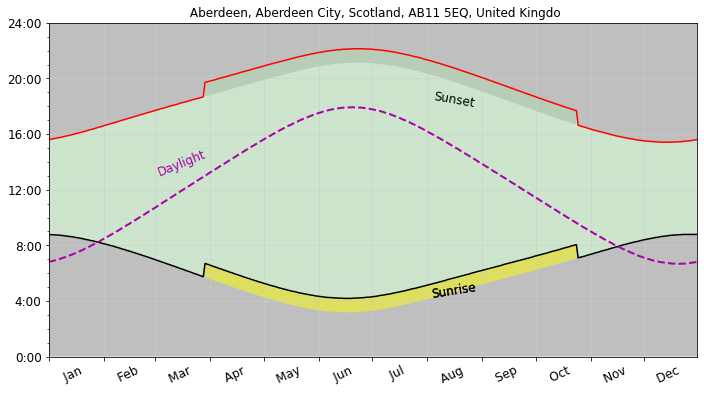

In [10]:
df_aberdeen = sunGraph('aberdeen')

gof
1
2
3
4
5
6
7
8
9
10
11
12


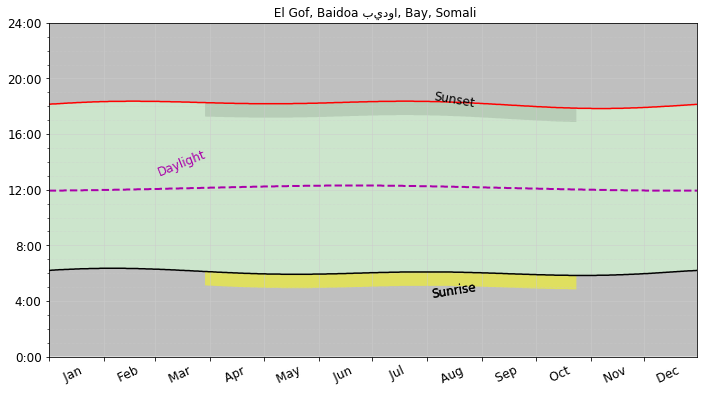

In [591]:
df_gof = sunGraph('gof')

In [565]:
#compare two locations
def sunCompare(dfA, dfB):
  
    dfA_x = dfA.index.values
    dfB_x = dfB.index.values
     # Create figure and plot sunrise + sunset
    fig, ax = plt.subplots(figsize=(10,6))
    plt.plot_date(dfA_x, dfA.Sunrise, 'k-.')
    plt.plot_date(dfA_x, dfA.Sunset, 'r-.')

    plt.plot_date(dfB_x, dfB.Sunrise, 'k-', label = '(%s)'%dfA.Location[0] )
    plt.plot_date(dfB_x, dfB.Sunset, 'r-', label = '(%s)'%dfB.Location[0] )
    
    plt.plot(x, dfA['Day length'], color='k', linestyle='--', lw=2)
    plt.plot(x, dfB['Day length'], color='r', linestyle='--', lw=2)
    
        # find point where dlA !> dlB
    intersection = dfA['Day length']>dfB['Day length']
    # find intersections

    res1 = next((idx for idx, val in enumerate(intersection) if val), None) 
    res2 = next((idx for idx, val in enumerate(intersection[res1:]) if val==False), None) 

    plt.plot([x[res1],x[res1]],[0,24], color='k', linestyle='-', linewidth=2)
    plt.plot([x[res2+res1],x[res2+res1]],[0,24], color='k', linestyle='-', linewidth=2)
    ax.text(x[res1], 2, x[res1], fontsize=12, color='black', ha='left')
    ax.text(x[res1+res2], 2, x[res1+res2], fontsize=12, color='black', ha='left')
    ax.legend()

    

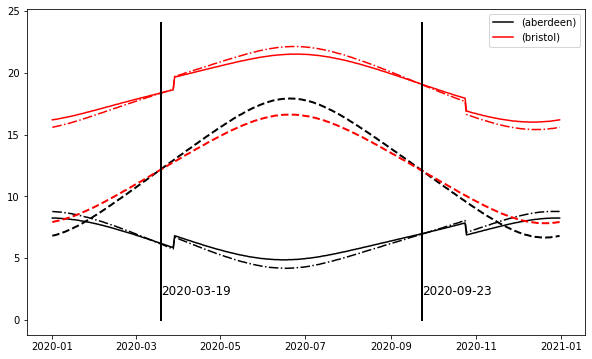

In [566]:
intersection = sunCompare(df_aberdeen,df_bristol)